In [11]:
import numpy as np
from pymanopt import Problem
from pymanopt.manifolds import SpecialOrthogonalGroup
from pymanopt.optimizers import SteepestDescent
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import torch

# align gaussian blob

In [2]:
def f1(xyz, mu, inv_sigma):
    """
    Gaussian function centered at mu with covariance matrix sigma.
    """
    diff = xyz - mu
    exponent = -0.5 * torch.sum(diff @ inv_sigma * diff, axis=1)
    return np.exp(exponent)

In [3]:
np.random.seed(0)
xyz = np.random.rand(100, 3)

# Define the Gaussian parameters
dtype = torch.float64
mu = torch.tensor([0, 0, 0]).to(dtype)
inv_sigma = (torch.diag(torch.tensor([1.0, 2.0, 3.0])) / 0.1).to(dtype)

n_pix = 128
x = y = z = torch.linspace(-1, 1, n_pix).to(dtype)
xx, yy, zz = torch.meshgrid(x, y, z)
xyz = torch.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T

f = f1(xyz, mu, inv_sigma).numpy()

/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1728232358512/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


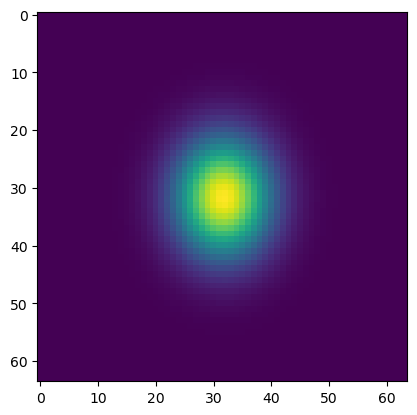

In [ ]:
# from cryo_challenge._preprocessing.fourier_utils import downsample_volume
# ds = downsample_volume(torch.from_numpy(f.reshape(n_pix,n_pix,n_pix)), 64)
# plt.imshow(ds[32])

# two = torch.stack([torch.from_numpy(f.reshape(n_pix,n_pix,n_pix)), torch.from_numpy(f.reshape(n_pix,n_pix,n_pix))])
# downsample_volume(two, 64).shape

In [14]:
torch.linalg.norm(torch.ones(3, 3, 3) - torch.zeros(3, 3, 3))

tensor(5.1962)

ValueError: too many values to unpack (expected 3)

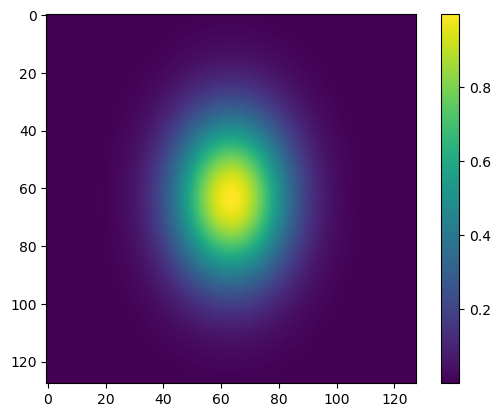

In [153]:
plt.imshow(f.reshape(n_pix, n_pix, n_pix)[:, :, n_pix // 2])
plt.colorbar()

In [182]:
fixed_rotation = torch.from_numpy(
    R.from_euler("ZXZ", [45, 0, 0], degrees=True).as_matrix()
)
f_fixed = f1(xyz @ fixed_rotation.T, mu, inv_sigma)
fixed_rotation

tensor([[ 0.7071, -0.7071,  0.0000],
        [ 0.7071,  0.7071,  0.0000],
        [ 0.0000,  0.0000,  1.0000]], dtype=torch.float64)

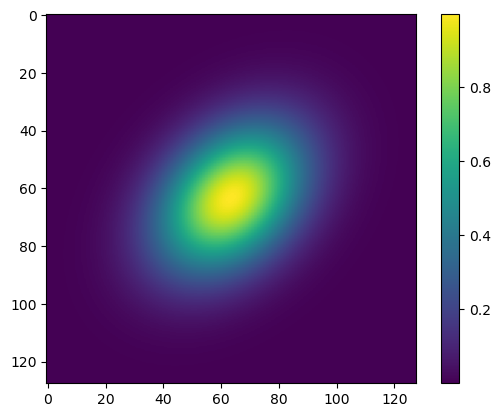

In [183]:
plt.imshow(f_fixed.reshape(n_pix, n_pix, n_pix)[:, :, n_pix // 2])
plt.colorbar()

In [ ]:
import torch
import matplotlib.pyplot as plt

# # Define the Gaussian parameters
# mu = torch.tensor([0.5, 0.5, 0.5], requires_grad=False).to(dtype)
# inv_sigma = (torch.diag(torch.tensor([1.0, 2.0, 3.0], requires_grad=False)) / 0.1**2).to(dtype)


# Define the Gaussian function with a 3x3 covariance matrix
def f1(xyz, mu, inv_sigma):
    """
    Gaussian function centered at mu with covariance matrix sigma.
    """
    diff = xyz - mu
    exponent = -0.5 * torch.sum(diff @ inv_sigma * diff, axis=1)
    return torch.exp(exponent)


# Define the loss function (L2 loss)
# @pymanopt.function.pytorch(SpecialOrthogonalGroup(3))
def loss(rotation):
    # Apply the rotation R to the coordinates
    rotated_xyz = xyz @ rotation.T
    # Compute the L2 loss between the two functions
    return torch.sum((f1(rotated_xyz, mu, inv_sigma) - f_fixed) ** 2)


# Generate a grid of 3D coordinates using meshgrid
# n_pix = 128
# dtype = torch.float64
# x = y = z = torch.linspace(0, 1, n_pix).to(dtype)
# xx, yy, zz = torch.meshgrid(x, y, z)
# xyz = torch.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T


# Compute the fixed function values
fixed_rotation = torch.from_numpy(
    R.from_euler("ZXZ", [45, 0, 0], degrees=True).as_matrix()
)
f_fixed = f1(xyz @ fixed_rotation.T, mu, inv_sigma)

# Define the manifold
manifold = SpecialOrthogonalGroup(3)

# Define the problem
problem = Problem(manifold=manifold, cost=loss)


# Custom Steepest Descent solver with a stopping criterion based on the objective function value
class CustomSteepestDescent(SteepestDescent):
    def __init__(self, min_objective_value, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_objective_value = min_objective_value

    def should_stop(self, state):
        if state.cost <= self.min_objective_value:
            return True
        return super().should_stop(state)


# Set the minimum objective value for stopping
min_objective_value = 1e-1

# Solve the problem with the custom solver
optimizer = CustomSteepestDescent(
    min_objective_value=min_objective_value,
    max_iterations=100,
)

initial_point = R.from_euler("ZXZ", [44, 0, 0], degrees=True).as_matrix()

result = optimizer.run(problem, initial_point=initial_point)

print("Optimal rotation matrix (R):")
print(result)

# Visualize the result
f = f1(xyz, mu, inv_sigma).detach().numpy()
plt.imshow(f.reshape(n_pix, n_pix, n_pix).sum(2))
plt.show()

NameError: name 'xyz' is not defined

In [157]:
result.point

array([[ 7.07106781e-01, -7.07106781e-01, -1.07365669e-20],
       [ 7.07106781e-01,  7.07106781e-01,  9.34042290e-21],
       [ 9.87222871e-22, -1.41965756e-20,  1.00000000e+00]])

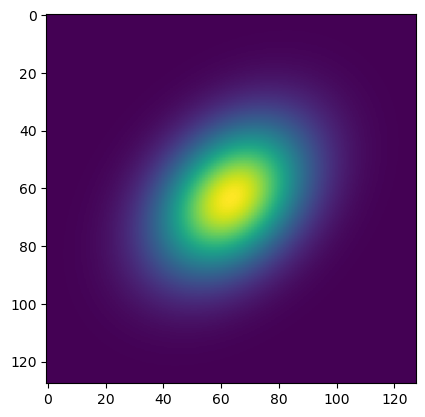

In [156]:
plt.imshow(f_fixed.reshape(n_pix, n_pix, n_pix).sum(2))

In [125]:
def loss(rotation):
    # Apply the rotation R to the coordinates
    rotated_xyz = xyz @ rotation.T
    # Compute the L2 loss between the two functions
    return torch.sum((f1(rotated_xyz, mu, inv_sigma) - f_fixed) ** 2)


angles = torch.linspace(44, 45, 100)
res = [
    loss(
        torch.from_numpy(R.from_euler("ZXZ", [x, 0, 0], degrees=True).as_matrix())
    ).item()
    for x in angles
]

<Axes: >

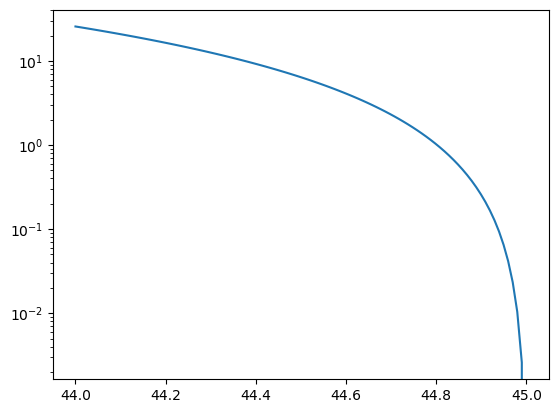

In [127]:
import pandas as pd

sr = pd.Series(res)
sr.index = angles.numpy()
sr.plot(logy=True)

# align voxelalized array
- do linear interpolation with torch.

In [ ]:
torch.nn.functional.grid_sample(..., mode="bilinear", padding_mode="zeros")

In [381]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Example 3D array (volume)
n_pix = 128
inv_sigma = (torch.diag(torch.tensor([1, 2, 10])) / 0.1).to(dtype)

volume = f_fixed = f1(xyz, mu, inv_sigma).reshape(1, 1, n_pix, n_pix, n_pix)

# Generate grid points
x = y = z = torch.linspace(-1, 1, n_pix).to(dtype)
xx, yy, zz = torch.meshgrid(x, y, z)
grid = torch.stack([xx, yy, zz], dim=-1)  # Shape: (D, H, W, 3)
# Reshape grid to match the expected input shape for grid_sample
grid = grid.unsqueeze(0)  # Add batch dimension, shape: (1, D, H, W, 3)


def voxelized_f1(volume, rotaiton, grid):
    grid = grid @ rotaiton.T
    # Interpolate the 3D array at the grid points
    interpolated_volume = F.grid_sample(
        volume,
        grid[..., [2, 1, 0]],
        mode="bilinear",
        padding_mode="zeros",
        align_corners=True,
    ).reshape(n_pix, n_pix, n_pix)
    return interpolated_volume


interpolated_volume = voxelized_f1(volume, fixed_rotation, grid)

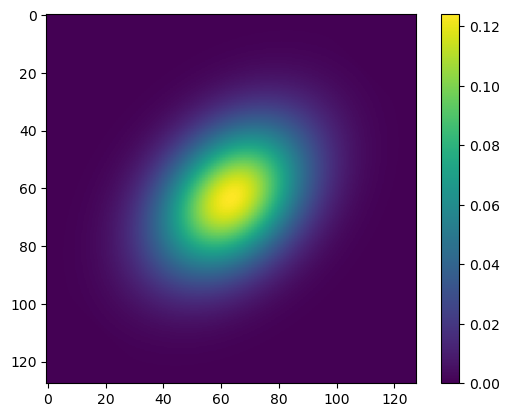

In [382]:
# Visualize a slice of the interpolated volume
slice_index = n_pix // 2
plt.imshow(interpolated_volume.mean(-1).detach().numpy())
plt.colorbar()
plt.show()

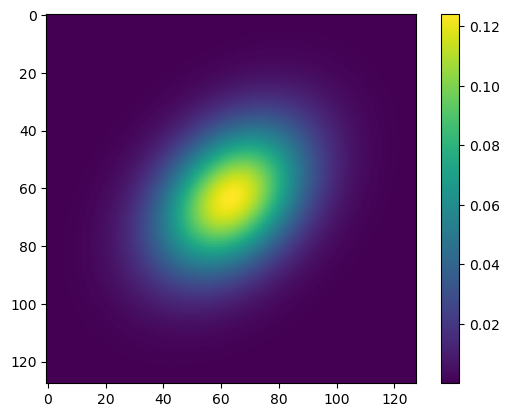

In [383]:
fixed_rotation = torch.from_numpy(
    R.from_euler("ZXZ", [45, 0, 0], degrees=True).as_matrix()
)
f_fixed = f1(xyz @ fixed_rotation.T, mu, inv_sigma).reshape(n_pix, n_pix, n_pix)

plt.imshow(f_fixed.reshape(n_pix, n_pix, n_pix).mean(-1))
plt.colorbar()
plt.show()

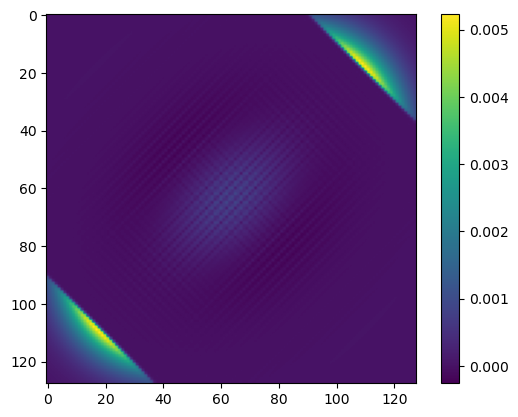

In [384]:
plt.imshow(
    f_fixed.reshape(n_pix, n_pix, n_pix)[:, :, n_pix // 2]
    - interpolated_volume.reshape(n_pix, n_pix, n_pix)[:, :, slice_index]
    .detach()
    .numpy()
)
plt.colorbar()
plt.show()

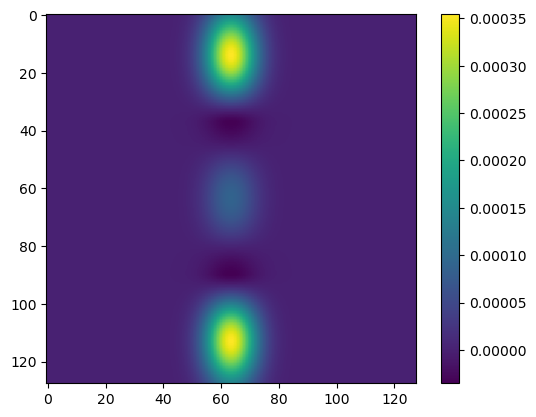

In [385]:
plt.imshow(
    f_fixed.reshape(n_pix, n_pix, n_pix).mean(-3)
    - interpolated_volume.mean(-3).detach().numpy()
)
plt.colorbar()
plt.show()

## optimize

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
  1          +4.4627700751132859e-01    3.10572420e+01    
  2          +8.9893280785535379e-02    8.27655179e+00    
  3          +7.3875176338842330e-02    5.29975762e+00    
  4          +6.4879580416269372e-02    2.32411126e+00    
  5          +6.2745227783972957e-02    1.16762361e-01    
  6          +6.2741370999084792e-02    6.27487677e-02    
  7          +6.2739888582970124e-02    1.45118098e-02    
  8          +6.2739805757591666e-02    1.53897581e-03    
  9          +6.2739804947050309e-02    5.75094324e-04    
 10          +6.2739804853897879e-02    3.10722313e-04    
 11          +6.2739804817233194e-02    6.61198429e-05    
 12          +6.2739804815669917e-02    2.10093904e-05    
 13          +6.2739804815495737e-02    2.37361425e-06    
 14          +6.2739804815494613e-02    5.08932505e-07    
Terminated - min grad norm reached after 1

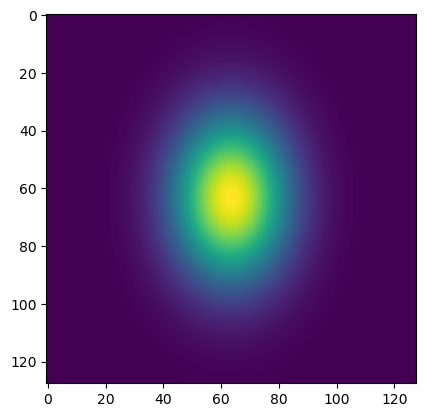

In [ ]:
import torch
import matplotlib.pyplot as plt
from pymanopt import Problem
from pymanopt.manifolds import SpecialOrthogonalGroup
from pymanopt.optimizers import SteepestDescent


# # Define the Gaussian parameters
# mu = torch.tensor([0.5, 0.5, 0.5], requires_grad=False).to(dtype)
# inv_sigma = (torch.diag(torch.tensor([1.0, 2.0, 3.0], requires_grad=False)) / 0.1**2).to(dtype)


# Define the Gaussian function with a 3x3 covariance matrix
def f1(xyz, mu, inv_sigma):
    """
    Gaussian function centered at mu with covariance matrix sigma.
    """
    diff = xyz - mu
    exponent = -0.5 * torch.sum(diff @ inv_sigma * diff, axis=1)
    return torch.exp(exponent)


# Define the loss function (L2 loss)
# @pymanopt.function.pytorch(SpecialOrthogonalGroup(3))
def loss(rotation):
    # Apply the rotation R to the volume
    interpolated_volume = voxelized_f1(volume, rotation, grid)
    # Compute the L2 loss between the two functions
    return torch.sum((interpolated_volume - f_fixed) ** 2)


# Generate a grid of 3D coordinates using meshgrid
# n_pix = 128
# dtype = torch.float64
# x = y = z = torch.linspace(0, 1, n_pix).to(dtype)
# xx, yy, zz = torch.meshgrid(x, y, z)
# xyz = torch.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T


# Define the manifold
manifold = SpecialOrthogonalGroup(3)

# Define the problem
problem = Problem(manifold=manifold, cost=loss)

# Solve the problem with the custom solver
optimizer = SteepestDescent(
    max_iterations=100,
)

initial_point = R.from_euler("ZXZ", [44, 0, 0], degrees=True).as_matrix()

result = optimizer.run(problem, initial_point=initial_point)

print("Optimal rotation matrix (R):")
print(result)

# Visualize the result
f = f1(xyz, mu, inv_sigma).detach().numpy()
plt.imshow(f.reshape(n_pix, n_pix, n_pix).sum(2))
plt.show()

# inspect

In [3]:
fname = "/mnt/home/gwoollard/ceph/repos/Cryo-EM-Heterogeneity-Challenge-1/src/cryo_challenge/_map_to_map/alignment/alignments_ni80_nj80_ds32.pt"
results = torch.load(fname)

/tmp/ipykernel_1298110/3487421044.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results = torch.load(fname)


Text(0.5, 1.0, 'Histogram of L2 loss values')

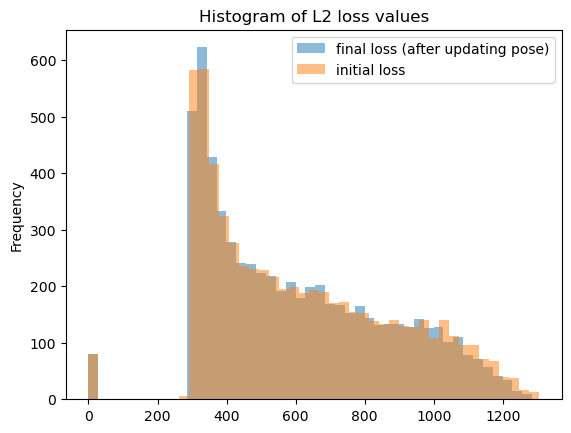

In [9]:
import pandas as pd

pd.Series(results["loss_final"].numpy().flatten()).plot.hist(
    bins=45, alpha=0.5, label="final loss (after updating pose)", legend=True
)
pd.Series(results["loss_initial"].numpy().flatten()).plot.hist(
    bins=45, alpha=0.5, label="initial loss", legend=True
)
plt.title("Histogram of L2 loss values")

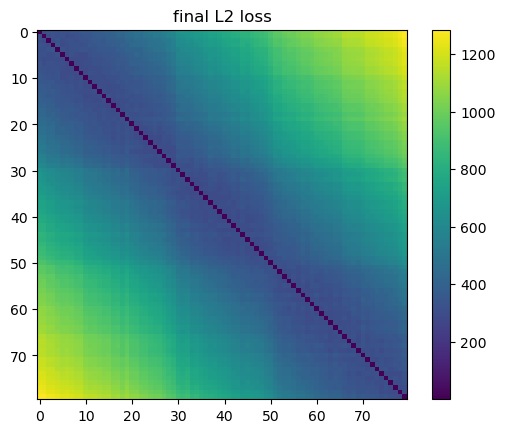

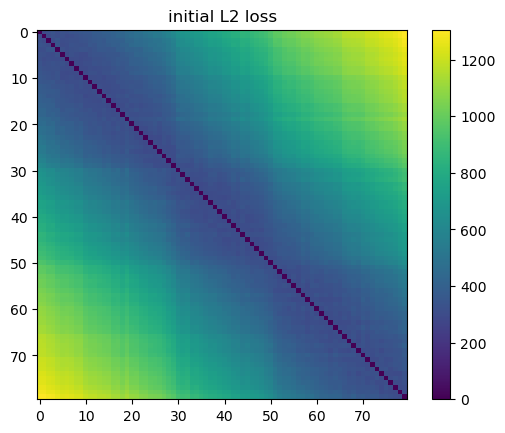

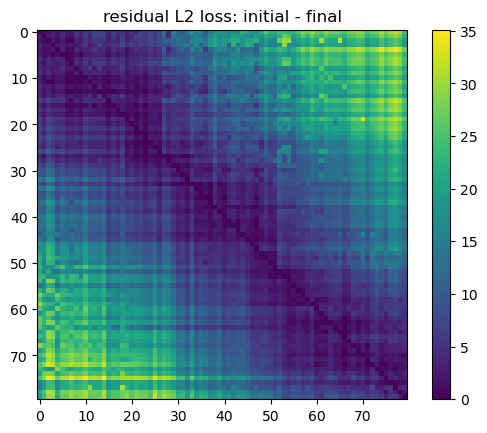

In [10]:
plt.imshow(results["loss_final"].numpy())
plt.colorbar()
plt.title("final L2 loss")
plt.show()

plt.imshow(results["loss_initial"].numpy())
plt.title("initial L2 loss")
plt.colorbar()
plt.show()

# residual
plt.imshow(results["loss_initial"].numpy() - results["loss_final"].numpy())
plt.title("residual L2 loss: initial - final")
plt.colorbar()
plt.show()

In [6]:
rotations = results["alignments"].reshape(-1, 3, 3)
b, n = len(rotations), 3
trace = torch.einsum("...ii", rotations)
geodesic_angle = torch.arccos((trace - 1) / 2)
geodesic_angle_deg = torch.rad2deg(geodesic_angle)
geodesic_angle_deg = geodesic_angle_deg.reshape(results["alignments"].shape[:2])

Text(0.5, 1.0, 'rotation distance: geodesic angle (deg)')

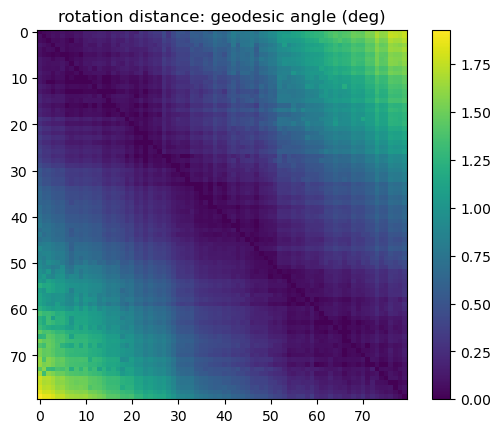

In [7]:
plt.imshow(geodesic_angle_deg)
plt.colorbar()
plt.title("rotation distance: geodesic angle (deg)")